# Linear regression

In Unit 2, we covered the basics of how to use PyMC for automated Bayesian inference. Later in the course (Units 4 & 5), we will dive into more PyMC details to better understand how the sampling and function fitting algorithms work.

In this unit, we use PyMC to build simple and complicated statistical models, to check how well our models work, and to improve on models when we discover problems with them.

We start with linear regression which starts out simple but actually forms the basis for a powerful class of models. For example, we can (and soon will) fit data like this using linear regression.

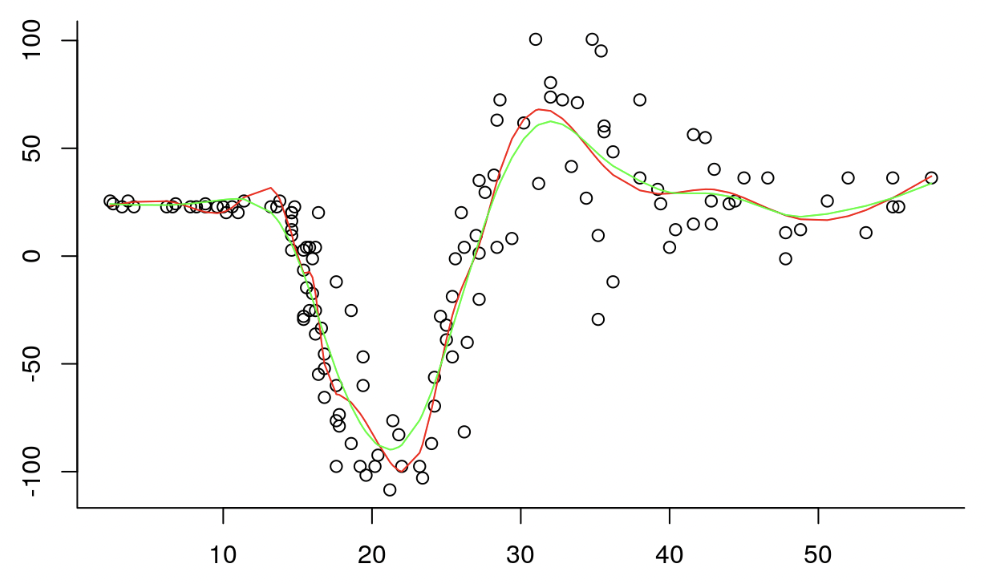

[[Image source](https://lbelzile.github.io/lineaRmodels/splines.html)]

## Prep plan

* There is a long section to read from McElreath today and you will spend almost all of your time on that.
* There are 2 questions to answer in this workbook.
* Most of this workbook contains a Python translation of the R code in McElreath, so you can run and read the code here as you read through the text.


## Review

The following CS114 topics are important today:

* **The Normal distribution.**
  * A continuous distribution with two parameters: the mean $\mu$ (location) and the standard deviation $\sigma$ (scale).
  * It is symmetric, bell-shaped, and unimodal, with about 68% of probability mass within one standard deviation of the mean, and 95% within two.
  * It arises often due to the Central Limit Theorem and is the default assumption in many models for measurement error or population variability.

* **Credible intervals.**
  * “Credible” means “believable” or “plausible”.
  * For any probability distribution, a credible interval is an interval containing a specified fraction (for example, 89% or 95%) of the probability mass.
  * In Bayesian inference, _credible_ intervals replace the notion of _confidence_ intervals from Frequentist statistics.
  * Credible intervals arise naturally from the posterior distribution. The credible interval directly answers: “Given the data and model, what range of parameter values are most plausible?”

In CS146, we have already discussed the prior, prior-predictive, posterior, and posterior-predictive distributions. It is important to understand the differences between these distributions and where they show up during the modeling and inference process.

* **Prior**, $P(\Theta)$: The distribution expressing our knowledge or assumptions about **parameters** $\Theta$ before seeing any data. It encodes beliefs or constraints, for example, positivity or plausible ranges.

* **Prior-predictive**, $P(D')$: The distribution of **possible data** values $D'$ generated by simulating from the model using only the prior. It shows what patterns the model would predict before seeing actual data and is useful for checking if priors are sensible.

* **Posterior**, $P(\Theta\mid D)$: The distribution of **parameters** after updating the prior with observed data $D$, via Bayes’ theorem. It represents revised knowledge about plausible parameter values after incorporating the data.

* **Posterior-predictive**, $P(D'\mid D)$: The distribution of **possible new data** values $D'$ generated by simulating from the model using parameters drawn from the posterior. It reflects both parameter uncertainty and the assumed data-generating process, and is used for prediction and model checking after incorporating the real (not simulated) data $D$.

## Required reading: Statistical rethinking

Read Section 4.4 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher's page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O'Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/12_Chapter04.xhtml#sec4_4). Log in with your library card number.

This section in McElreath on _Linear Prediction_ (8,240 words) is a long and detailed walk through basic linear regression. It is the foundation for more complicated linear regression that we will do in the next few lesson plans. **Read the whole section in detail. This will require most of your pre-class work time.**

The rest of this pre-class workbook contains the R code provided in the McElreath book, translated to Python and PyMC. This code was copied from the wonderful `pymc-resources` repository where you can find [code translations for the whole Statistical Rethinking textbook](https://github.com/pymc-devs/pymc-resources/tree/main/Rethinking_2) (and some other textbooks).

While reading Section 4.4, you need to follow along in this workbook and run the code as you go. **There are also some questions for you to answer.**

In class, we will apply the same linear model to a different dataset and explore the impact of outliers in linear models.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

In [2]:
# Set the default credible interval to match the textbook
az.rcParams["stats.ci_prob"] = 0.89

### Load the data used in Section 4.4

In [3]:
url = "https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Howell1.csv"
data = pd.read_csv(url, sep=";", header=0)
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# Display a summary each of the variables (columns) in the data set.
# This is just for general information and not used anywhere.
az.summary(data.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
age,29.344,20.747,0.000,57.000
height,138.264,27.602,90.805,170.180
male,0.472,0.500,0.000,1.000
weight,35.611,14.719,11.368,55.707


In [5]:
# Filter the data to select adults only
data = data[data.age >= 18]

### Code from Section 4.4

Read the code as you progress through the section in the textbook.

#### Code 4.37: Data plot

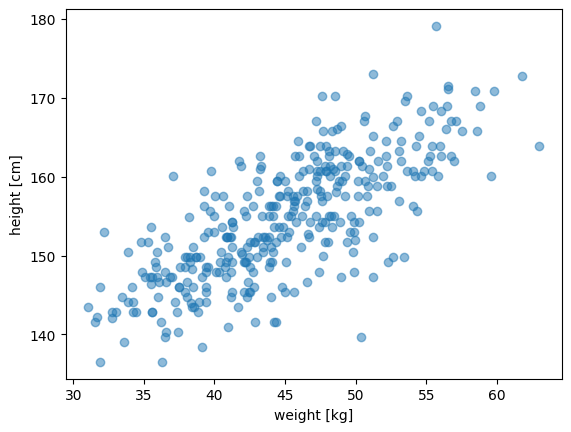

In [6]:
plt.scatter(data.weight, data.height, alpha=0.5)
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]");

#### Code 4.38 ad 4.39: Prior-predictive

In [7]:
np.random.seed(2971)  # Make it deterministic for reproducibility

N = 100  # 100 lines
a = stats.norm.rvs(loc=178, scale=20, size=N)
b = stats.norm.rvs(loc=0, scale=10, size=N)

#### Code 4.39 and 4.40: Prior-predictive plots

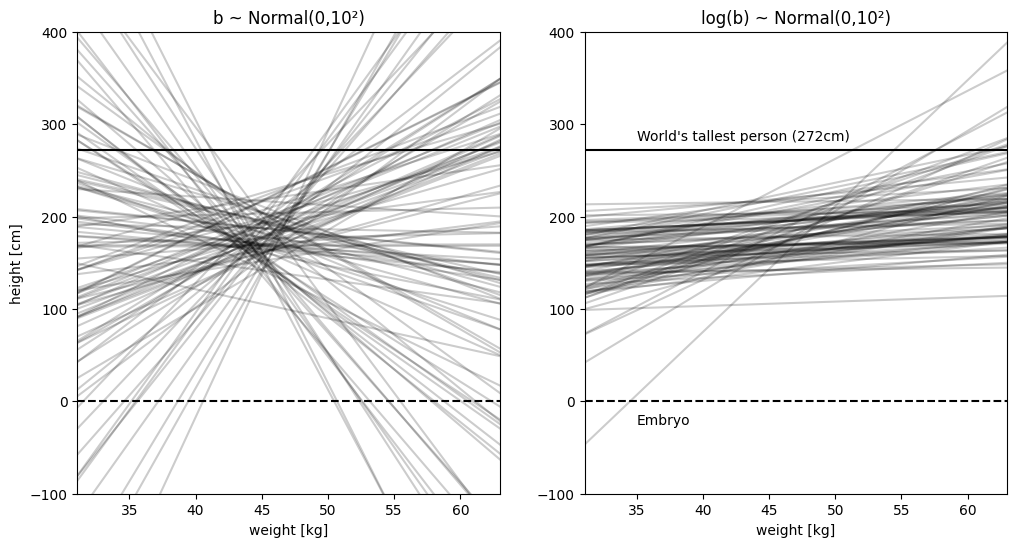

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

xbar = data.weight.mean()

ax[0].set_xlim(data.weight.min(), data.weight.max())
ax[0].set_ylim(-100, 400)
ax[0].set_xlabel("weight [kg]")
ax[0].set_ylabel("height [cm]")
ax[0].axhline(0, c="k", ls="--")
ax[0].axhline(272, c="k")
ax[0].set_title("b ~ Normal(0,10²)")
x = np.array([data.weight.min(), data.weight.max()])
for i in range(N):
    ax[0].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)

b = stats.lognorm.rvs(s=1, scale=1, size=100)

ax[1].set_xlim(data.weight.min(), data.weight.max())
ax[1].set_ylim(-100, 400)
ax[1].set_xlabel("weight [kg]")
ax[0].set_ylabel("height [cm]")
ax[1].axhline(0, c="k", ls="--", label="embryo")
ax[1].axhline(272, c="k")
ax[1].set_title("log(b) ~ Normal(0,10²)")
ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
ax[1].text(x=35, y=-25, s="Embryo");
for i in range(N):
    ax[1].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)

Why does it not matter that much whether we use the $\log b\sim\text{Normal}(0, 1)$ prior or the $b\sim\text{Normal}(0, 10)$ prior, even though the former is better than the latter?

In [9]:
# ENTER YOUR ANSWER IN YOUR FORUM PRE-CLASS WORKBOOK
'''
there is so much data that the priors do not end up mattering,
strictly positive
somehow it doesnt matter that much, only that we will get log b in the posterior
'''

'\nthere is so much data that the priors do not end up mattering,\nstrictly positive\nsomehow it doesnt matter that much, only that we will get log b in the posterior\n'

#### Code 4.42: Posterior approximation for the $b \sim \text{Normal}(0, 10)$ prior

In [10]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (data.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data.height.values)
    trace_4_3 = pm.sample(chains=4)
az.summary(trace_4_3)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,154.607,0.271,154.174,155.033,0.003,0.005,6499.0,3364.0,1.0
b,0.903,0.043,0.833,0.968,0.001,0.001,6362.0,3192.0,1.0
sigma,5.103,0.196,4.802,5.420,0.002,0.003,6329.0,3127.0,1.0


#### Code 4.43: Posterior approximation for the $\log b \sim \text{Normal}(0, 1)$ prior

In [11]:
# Model with the log(b) ~ Normal(0, 10) prior
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    log_b = pm.Normal("log_b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(log_b) * (data.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data.height.values)
    trace_4_3b = pm.sample(chains=4)
az.summary(trace_4_3b)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,154.598,0.272,154.154,155.011,0.003,0.004,6242.0,2993.0,1.0
log_b,-0.103,0.048,-0.171,-0.021,0.001,0.001,6613.0,2906.0,1.0
sigma,5.104,0.191,4.791,5.405,0.003,0.003,5815.0,3361.0,1.0


#### Code 4.44: Posterior summary

In [12]:
az.summary(trace_4_3, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.607,0.271,154.174,155.033
b,0.903,0.043,0.833,0.968
sigma,5.103,0.196,4.802,5.420


#### Code 4.45: Posterior covariance summary

In [13]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

,a,b,sigma
a,0.074,-0.000,0.001
b,-0.000,0.002,-0.000
sigma,0.001,-0.000,0.039


#### Code 4.46: Posterior mean plot

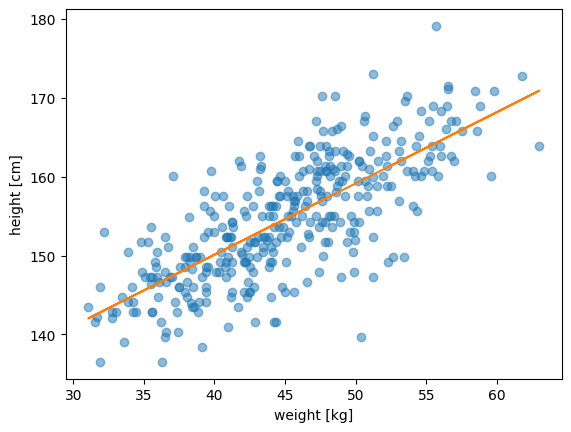

In [14]:
plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(
    data.weight,
    trace_4_3.posterior["a"].values.mean()
        + trace_4_3.posterior["b"].values.mean() * (data.weight - xbar),
    color='C1')
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]");

#### Code 4.47: Posterior samples

In [15]:
trace_4_3_df.head(5)

a         b     sigma
chain draw                                
0     0     155.092949  0.924581  5.050313
      1     154.638256  0.910488  5.349178
      2     154.259162  0.939398  5.097646
      3     154.646643  0.910025  4.981840
      4     154.715536  0.900445  5.328684

#### Code 4.48: Re-estimate the model for the first 10 cases only

In [16]:
N = 10
data_N = data[:N]
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (data_N.weight.values - data_N.weight.mean()))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data_N.height.values)
    trace_N = pm.sample(chains=4)
az.summary(trace_N)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,152.606,2.003,149.643,155.702,0.044,0.061,2244.0,1686.0,1.0
b,0.906,0.188,0.623,1.208,0.004,0.005,2549.0,1503.0,1.0
mu[0],154.571,2.042,151.503,157.672,0.045,0.065,2312.0,1592.0,1.0
mu[1],144.298,2.654,139.925,148.108,0.057,0.065,2259.0,1624.0,1.0
mu[2],140.112,3.291,135.017,145.203,0.070,0.083,2340.0,1770.0,1.0
mu[3],159.296,2.431,155.285,162.747,0.052,0.076,2411.0,1643.0,1.0
mu[4],148.638,2.172,145.256,151.926,0.048,0.057,2183.0,1667.0,1.0
mu[5],168.310,3.819,162.375,174.140,0.080,0.108,2492.0,1714.0,1.0
mu[6],145.890,2.450,142.253,149.780,0.053,0.060,2225.0,1665.0,1.0
mu[7],161.504,2.718,157.225,165.452,0.058,0.082,2438.0,1982.0,1.0


#### Code 4.49: Plot 20 posterior samples

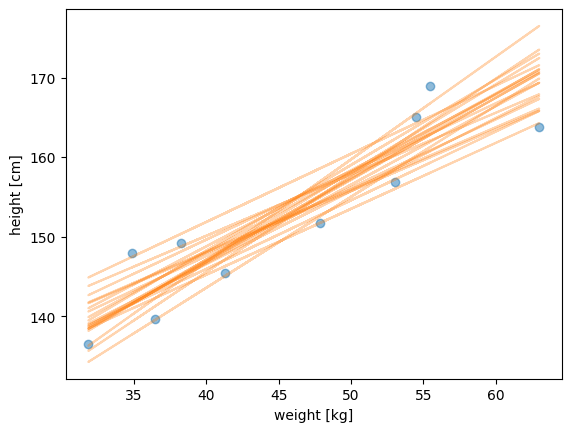

In [17]:
samples_N = az.extract(trace_N)

plt.scatter(data_N.weight, data_N.height, alpha=0.5)
nb_samples = samples_N.sizes["sample"]
idxs = np.random.randint(nb_samples, size=20)
for idx in idxs:
    plt.plot(
        data_N.weight,
        samples_N["a"].item(idx) + samples_N["b"].item(idx) * (data_N.weight - data_N.weight.mean()),
        "C1-", alpha=0.33)
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]");

Alternative we can directly use the deterministic `mu` variable

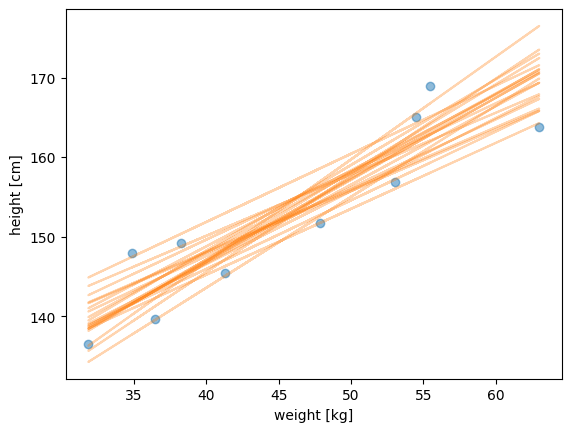

In [18]:
plt.scatter(data_N.weight, data_N.height, alpha=0.5)
for idx in idxs:
    plt.plot(data.weight[:N], samples_N["mu"][:, idx], "C1-", alpha=0.33)
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]");

In [19]:
# Re-estimate the model for different values of N.
# This cell will take about 30 seconds to run in Colab.

N = [10, 50, 150, 352]

data_N = []
traces = []
for n in N:
    d = data[:n]
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sigma=100)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = pm.Deterministic("mu", a + b * (d.weight.values - d.weight.mean()))
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
        traces.append(pm.sample(chains=4, progressbar=False))
        data_N.append(d)

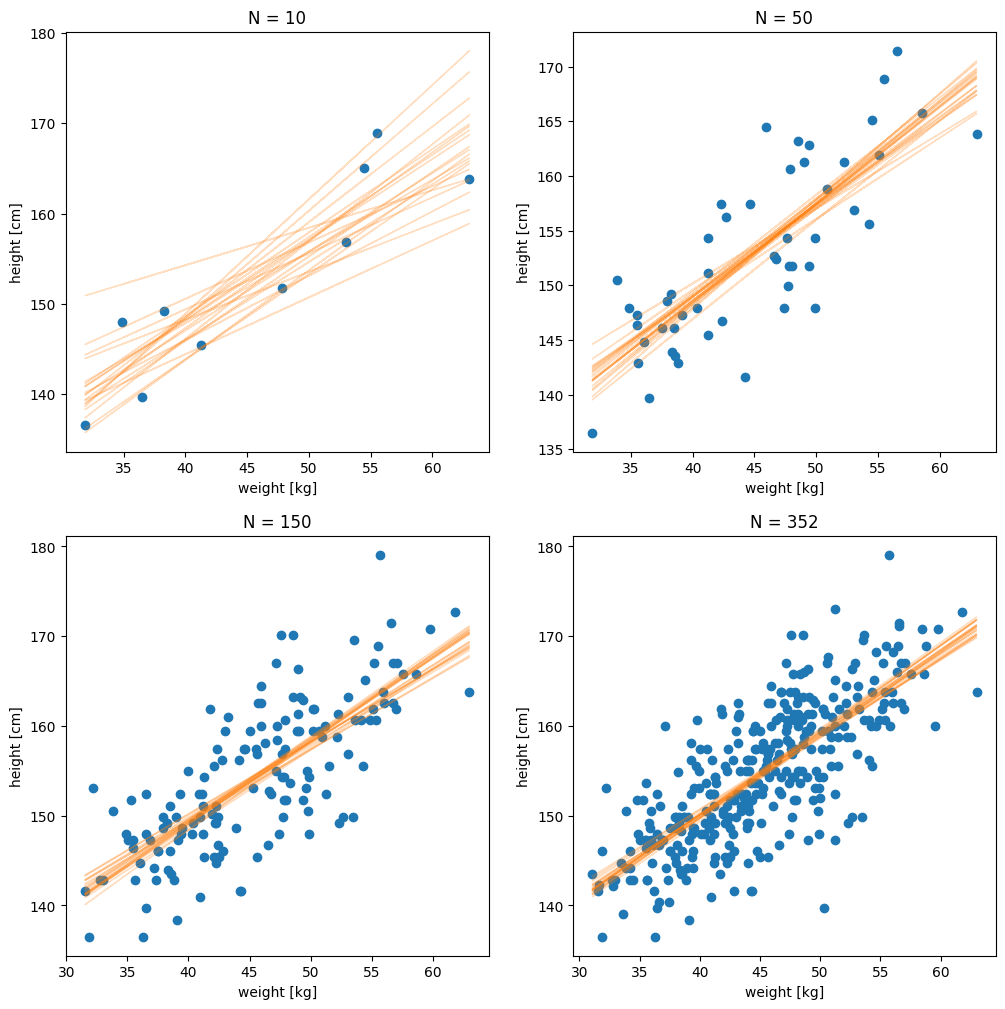

In [20]:
# Plot the results to produce Figure 4.7

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(len(data_N)):
    idxs = np.random.randint(nb_samples, size=20)
    ax[coords[i]].plot(data_N[i].weight, data_N[i].height, "C0o")
    ax[coords[i]].set_title(f'N = {N[i]}')
    ax[coords[i]].set_xlabel('weight [kg]')
    ax[coords[i]].set_ylabel('height [cm]')
    for idx in idxs:
        ax[coords[i]].plot(
            data_N[i].weight, az.extract(traces[i])["mu"][:, idx],
            "C1-", alpha=0.25, linewidth=1)

What do we learn from the four plots above? What do the orange lines represent and what happens as we increase $N$?

In [21]:
# ENTER YOUR ANSWER IN YOUR FORUM PRE-CLASS WORKBOOK
the samples from the posterior (the linear regresson lines), the
uncertainty of the regression relationship decreases. this
means that the model "grows more confident" about the
location of the mean as we increase the amount of data we consider.

SyntaxError: invalid syntax (ipython-input-4029273850.py, line 2)

#### Code 4.50

In [22]:
data_4_3 = az.extract(trace_4_3)
mu_at_50 = data_4_3["a"] + data_4_3["b"] * (50 - data.weight.mean())

#### Code 4.51: Predictive plot for weight = 50

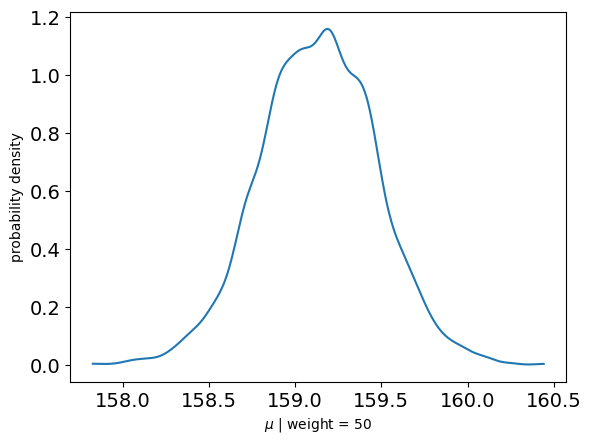

In [23]:
az.plot_kde(mu_at_50.values)
plt.xlabel(r"$\mu$ | weight = 50")
plt.ylabel("probability density");

#### Code 4.52: Posterior highest density interval

In [24]:
az.hdi(mu_at_50.values, hdi_prod=0.89)

array([158.60684943, 159.66970739])

#### Code 4.53 and 4.54

We are doing this _manually_. In the book, it is done using the ```link``` function. In the book in code 4.58, the following operations are performed _manually_.

In [25]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
nb_samples = samples_N.sizes["sample"]
trace_4_3_thinned = data_4_3.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - data.weight.mean())

#### Code 4.55

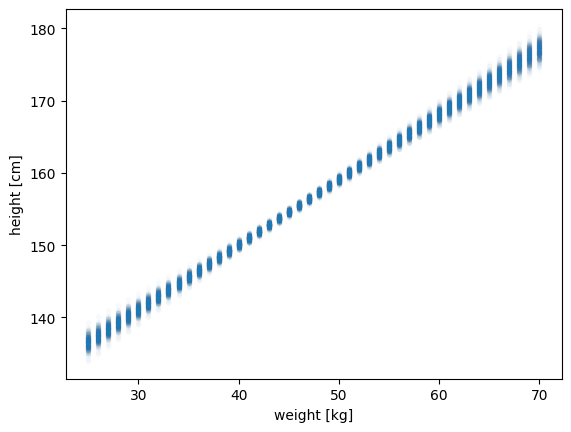

In [26]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.01)
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]");

#### Code 4.56: Summarize the distribution of mu

In [27]:
mu_mean = mu_pred.mean(axis=1)
mu_hdi = az.hdi(mu_pred.T)

/tmp/ipython-input-3362490103.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


#### Code 4.57

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


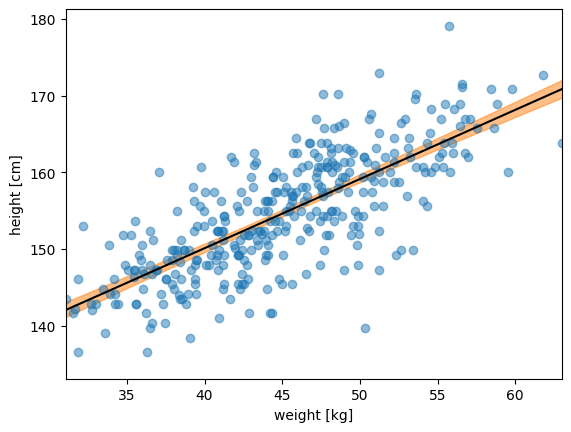

In [28]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]")
plt.xlim(data.weight.min(), data.weight.max());

#### Code 4.59: Posterior-predictive samples

Now we are going to use ```sample_posterior_predictive()``` from PyMC. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape is (200, 352)`

In [29]:
samp_size = 100
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)

Output()

#### Code 4.60

In [30]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"])

#### Code 4.61

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


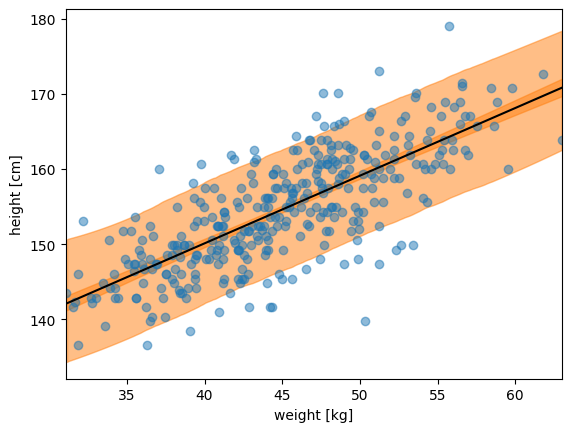

In [31]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(data.weight, height_pred.posterior_predictive["height"], ax=ax)
plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]")
plt.xlim(data.weight.min(), data.weight.max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values.

Output()

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


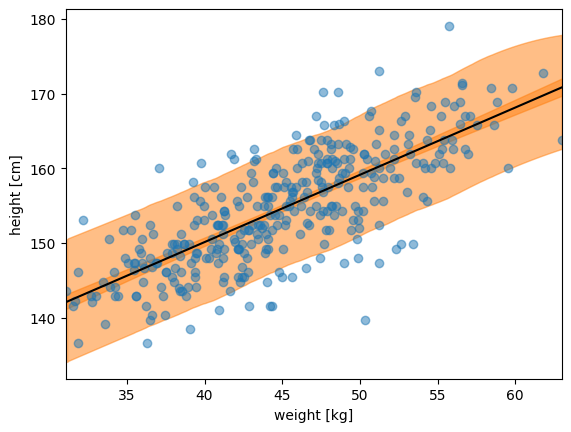

In [43]:
samp_size = 200
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)

ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(data.weight, height_pred.posterior_predictive["height"], ax=ax)
plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]")
plt.xlim(data.weight.min(), data.weight.max());

#### Code 4.63

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weight values, called `weight_seq`.

In [33]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(data_4_3))
    mu_pr = data_4_3["a"][i].item(0) + data_4_3["b"][i].item(0) * (weight_seq - data.weight.mean())
    sigma_pred = data_4_3["sigma"][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


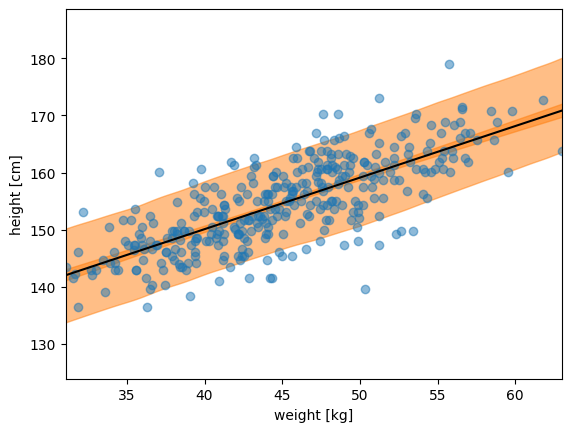

In [34]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax)
plt.scatter(data.weight, data.height, alpha=0.5)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight [kg]")
plt.ylabel("height [cm]")
plt.xlim(data.weight.min(), data.weight.max());